In [66]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import matplotlib.patches as mpatches
import warnings

warnings.filterwarnings("ignore")
plt.style.use('dark_background')
sns.set_palette("Set1")

In [67]:
features = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z']
#fi_cols = ['g-r', 'i-z', 'u-r', 'i-r', 'z-r', 'g']
fi_cols = ['u', 'g', 'r', 'g-r', 'i-z', 'u-r', 'i-r', 'z-r']
target = 'class'

In [68]:
def fetch_data(features):
    data = {f: [float(input("  '{}': ".format(f)))] for f in features}
    df = pd.DataFrame(data=data)
    print("Raw data is fetched successfully.")
    return df

In [69]:
df = fetch_data(features=features)

Raw data is fetched successfully.


In [70]:
def preprocess(df, features):
    scale = 'data/scaling.pkl'
    with open(file=scale, mode='rb') as pre_pkl:
        scaling = pickle.load(file=pre_pkl)
    
    df = scaling.transform(X=df)
    df = pd.DataFrame(data=df, columns=features)
    return df

In [71]:
df = preprocess(df=df, features=features)
display(df)

,ra,dec,u,g,r,i,z
0,0.002704,0.153533,-0.563851,-0.381922,-0.34947,-0.392635,-0.403245


In [72]:
def featurize(df):
    df['g-r'] = df['g'] - df['r']
    df['i-z'] = df['i'] - df['z']
    df['u-r'] = df['u'] - df['r']
    df['i-r'] = df['i'] - df['r']
    df['z-r'] = df['z'] - df['r']
    df = df[fi_cols]
    return df

In [73]:
df = featurize(df)

In [74]:
def prediction(X):
    with open(file="data/model_dumps/model_random_forest_classifier.pkl", mode="rb") as m_pkl:
        clf_tuple = pickle.load(file=m_pkl)
    clf = clf_tuple[1]
    pred_proba = clf.predict_proba(X=X)
    confidence = np.round(a=np.max(pred_proba) * 100, decimals=1)
    pred_class = clf.predict(X=X)[0]
    if pred_class == "QSO":
        pred_class = "Quasar"
    if pred_class == "STAR":
        pred_class = "Star"
    print(f"The predicted class is '{pred_class}' with a confidence of {confidence}%.")

In [75]:
prediction(X=df)

The predicted class is 'Star' with a confidence of 96.3%.


In [76]:
def ml_pipeline(features):
    df = fetch_data(features=features)
    df = preprocess(df=df, features=features)
    df = featurize(df=df)
    prediction(X=df)

In [77]:
ml_pipeline(features=features)

Raw data is fetched successfully.
The predicted class is 'Star' with a confidence of 97.6%.


In [78]:
def pipeline_for_whole_test_data(features, target='class'):
    data = pd.read_csv(filepath_or_buffer='data/test_data.csv')
    
    X_test = data[features]
    y_test = data[target].values
    
    X_test = featurize(df=X_test)
    
    with open(file="data/model_dumps/model_random_forest_classifier.pkl", mode="rb") as m_pkl:
        clf_tuple = pickle.load(file=m_pkl)
    print(clf_tuple)
    clf = clf_tuple[1]

    cm_pred = clf.predict(X=X_test)

    print(classification_report(y_true=y_test, y_pred=cm_pred))

In [79]:
pipeline_for_whole_test_data(features)

(RandomForestClassifier(criterion='log_loss', max_depth=100, min_samples_split=5,
                       n_estimators=250, n_jobs=-1, random_state=42), CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='log_loss',
                                                             max_depth=100,
                                                             min_samples_split=5,
                                                             n_estimators=250,
                                                             n_jobs=-1,
                                                             random_state=42)), {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'log_loss'})
              precision    recall  f1-score   support

         QSO       0.93      0.94      0.94     24757
        STAR       0.94      0.94      0.94     25241

    accuracy                           0.94     49998
   macro avg       0.94      0.94      0.94     49998
weighted avg  

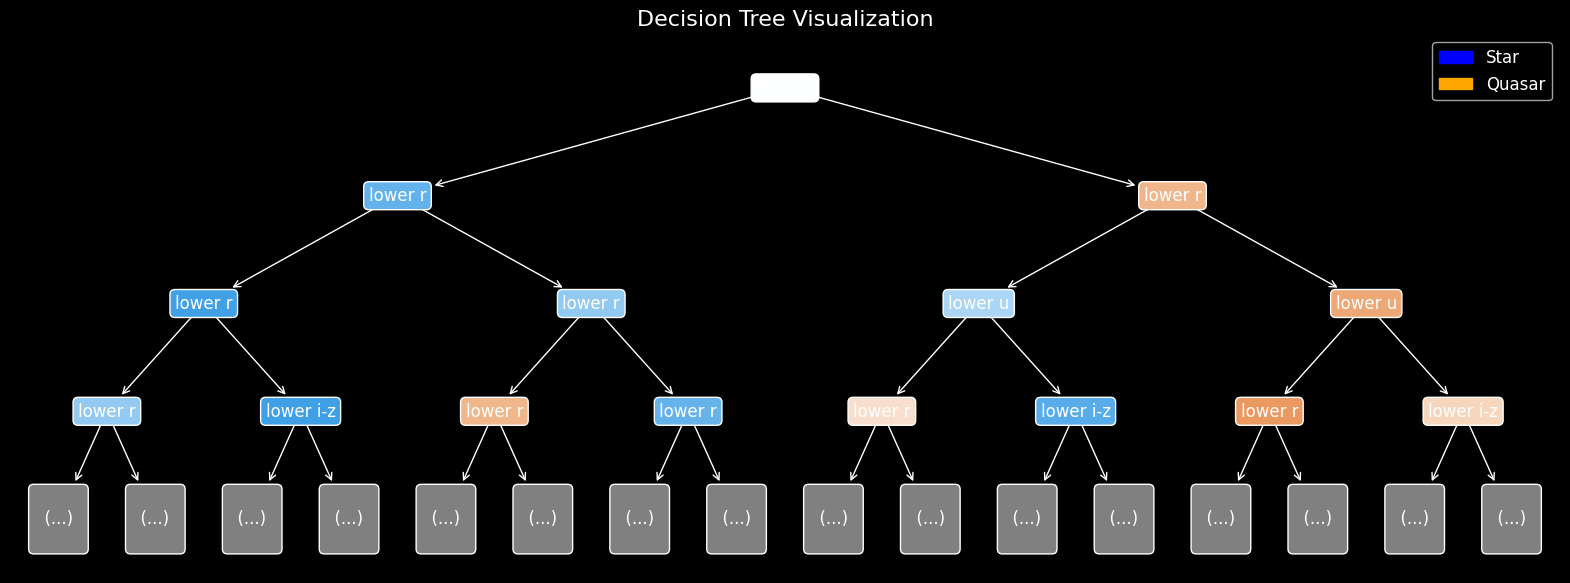

In [80]:
replacements = {
    'r <': 'lower r',
    'r >': 'greater r',
    'g-r <': 'lower g-r',
    'g-r >': 'greater g-r',
    'i-z <': 'lower i-z',
    'i-z >': 'greater i-z',
    'i-r <': 'lower i-r',
    'i-r >': 'greater i-r',
    'z-r <': 'lower z-r',
    'z-r >': 'greater z-r',
    'u-r <': 'lower u-r',
    'u-r >': 'greater u-r',
    'u <': 'lower u',
    'u >': 'greater u',
    'g <': 'lower g',
    'g >': 'greater g',
    'i <': 'lower i',
    'i >': 'greater i',
    'z <': 'lower z',
    'z >': 'greater z'
}

model = 'data/model_dumps/model_random_forest_classifier.pkl'
with open(file=model, mode='rb') as m_pkl:
    clf = pickle.load(file=m_pkl)

rf_clf = clf[0]
estimator = rf_clf.estimators_[0]

fig, axes = plt.subplots(figsize=(20, 7))

plot_tree(estimator, feature_names=df.columns, class_names=['Star', 'Quasar'], filled=True, ax=axes, max_depth=3, fontsize=12, rounded=True, precision=2)

star_patch = mpatches.Patch(color='blue', label='Star')
quasar_patch = mpatches.Patch(color='orange', label='Quasar')
plt.legend(handles=[star_patch, quasar_patch], loc='upper right', fontsize='larger')

for text in axes.get_figure().findobj(match=plt.Text):
    for key, value in replacements.items():
        if key in text.get_text():
            text.set_text(value)
            break

plt.title('Decision Tree Visualization', fontsize=16)

plt.show()